In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from qpfs import *
from kernels import *
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from time import time
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca

In [2]:
X_t_train = scipy.io.loadmat('./ECoG_data/ECoG_X_train.mat')['X_train']
X_m_train = X_t_train.reshape([-1, 32 * 27])
Ytrain = scipy.io.loadmat('./ECoG_data/ECoG_Y_train.mat')['Y_train']

X_t_train = (X_t_train - X_t_train.mean(axis=0)) / X_t_train.std(axis=0)
X_m_train = (X_m_train - X_m_train.mean(axis=0)) / X_m_train.std(axis=0)
Y_train = (Ytrain - Ytrain.mean(axis=0)) / Ytrain.std(axis=0)

X_t_test = scipy.io.loadmat('./ECoG_data/ECoG_X_test.mat')['X_hold_out']
X_m_test = X_t_test.reshape([-1, 32 * 27])
Ytest = scipy.io.loadmat('./ECoG_data/ECoG_Y_test.mat')['Y_hold_out']

X_t_test = (X_t_test - X_t_test.mean(axis=0)) / X_t_test.std(axis=0)
X_m_test = (X_m_test - X_m_test.mean(axis=0)) / X_m_test.std(axis=0)
Y_test = (Ytest - Ytest.mean(axis=0)) / Ytest.std(axis=0)

n_samples, n_features = X_m_train.shape

print('Tensor X_train shape:', X_t_train.shape, '   Matrix X_train shape:', X_m_train.shape,'   Y_train shape:',  Y_train.shape)
print('Tensor X_test shape:', X_t_test.shape, '   Matrix X_test shape:', X_m_test.shape, '   Y_test shape:', Y_test.shape)

Tensor X_train shape: (12801, 32, 27)    Matrix X_train shape: (12801, 864)    Y_train shape: (12801, 3)
Tensor X_test shape: (6087, 32, 27)    Matrix X_test shape: (6087, 864)    Y_test shape: (6087, 3)


# PLS

In [3]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [4]:
def RMSE(Y_pred,Y):
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [03:48<00:00, 12.05s/it]


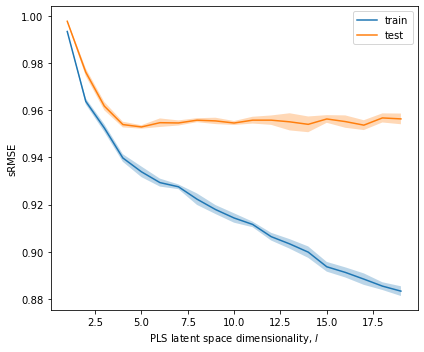

5 components with nRMSE = 0.9529443234751426


In [5]:
step = 3
n_restarts = 5

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 20)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [6]:
start = time()
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
PLS_time = end-start
PLS_rmse_test = np.mean(te)
PLS_rmse_train = np.mean(tr)
PLS_rmse_test_std = np.std(te)
PLS_rmse_train_std = np.std(te)
print('Time:', PLS_time)
print('Train rmse:', PLS_rmse_train,'±',PLS_rmse_train_std)
print('Test rmse:', PLS_rmse_test,'±',PLS_rmse_test_std)

Time: 8.794427394866943
Train rmse: 0.9350406706978106 ± 0.0012045644009490548
Test rmse: 0.9542746938016619 ± 0.0012045644009490548


# QPFS + PLS

In [7]:
n_samples, n_features = X_m_train.shape
qpfs = QPFS()
mqpfs = MultivariateQPFS()
steps = [3, 5, 10]
n_restarts = 3
modes = ['RelAgg','AsymImp']

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
    Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]
    print('step', step)
    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

    qpfs.fit(Xtrain_ar, Ytrain_ar)
    
    score_history = [qpfs.zx]
    
    mqpfs.get_params(Xtrain_ar, Ytrain_ar)
    for mode in modes[1:]:
        alphas = mqpfs.get_alpha(mode)
        mqpfs.solve_problem(alphas, mode)
        score_history.append(mqpfs.zx)
    
    n_active_array = np.arange(1, n_features // 2, 10)
    
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        results = get_metrics(n_active_array, modes, score_history, 
                              X, Y, Xtest_ar, Ytest_ar)

step 3
(12799, 9) (12799, 864) (6085, 9) (6085, 864)


KeyboardInterrupt: 

In [ ]:
from itertools import combinations
lr = LinearRegression()
step = 3
n_restarts = 3

modes = ['RelAgg', 'AsymImp']

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

for i in range(1,2):
    print(modes[i])
    sh = [np.array(s)[:n_features] for s in score_history]
    corrs = []
    l2s = []
    l1s = []
    comps = []
    hams = []
    rmse = []
    for s1, s2 in combinations(sh, 2):
        corrs.append(sc.stats.spearmanr(s1, s2)[0])
        l2s.append(np.sqrt(np.sum((s1 - s2) ** 2)))
        l1s.append(np.sum(np.abs(s1 - s2)))
        hams.append(sc.spatial.distance.hamming(s1 > 1e-3, s2 > 1e-3))
        
    for s1 in sh:
        comps.append(np.sum(s1 > 1e-6))
        active_idxs = s1.argsort()[::-1][:100]#[:np.sum(s1 > 1e-3)]
        lr.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append(metric_rmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs)
    
    mean_l2 = np.mean(l2s)
    std_l2 = np.std(l2s)
    
    mean_l1 = np.mean(l1s)
    std_l1 = np.std(l1s)
    
    mean_comp = np.mean(comps)
    std_comp = np.std(comps)
    
    mean_ham = np.mean(hams)
    std_ham = np.std(hams)
    
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    
    print(f'corr {mean_corr:.3f} $\pm$ {std_corr:.3f}')
    print(f'l2 {mean_l2:.3f} $\pm$ {std_l2:.3f}')
    print(f'l1 {mean_l1:.3f} $\pm$ {std_l1:.3f}')
    print(f'comp {mean_comp:.1f} $\pm$ {std_comp:.1f}')
    print(f'ham {mean_ham:.3f} $\pm$ {std_ham:.3f}')
    print(f'rmse {mean_rmse:.3f} $\pm$ {std_rmse:.3f}')
    print('-' * 80)

In [ ]:
n_restarts = 5
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]

rmse = []
for k in tqdm(range(1, 20)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_QPFS+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [ ]:
step = 3
mode = 'AsymImp'
n_samples, n_features = X_m_train.shape
Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

start = time()

qpfs.fit(Xtrain_ar, Ytrain_ar)

score_history = [qpfs.zx]

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha(mode)
mqpfs.solve_problem(alphas, mode)
score_history.append(mqpfs.zx)

n_active_array = np.arange(1, n_features // 2, 10)

for s1 in sh:
    comps.append(np.sum(s1 > 1e-6))
    active_idxs = s1.argsort()[::-1][:100]

Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    
end = time()
QPFS_PLS_time = end-start
QPFS_PLS_rmse_test = np.mean(te)
QPFS_PLS_rmse_train = np.mean(tr)
QPFS_PLS_rmse_test_std = np.std(te)
QPFS_PLS_rmse_train_std = np.std(te)
print('Time:', QPFS_PLS_time)
print('Train rmse:', QPFS_PLS_rmse_train,'±',QPFS_PLS_rmse_train_std)
print('Test rmse:', QPFS_PLS_rmse_test,'±',QPFS_PLS_rmse_test_std)

# HOPLS

In [ ]:
from GenerateData import generateComplex
import os
import sys
import warnings
import torch
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from scipy.io import loadmat, savemat
from joblib import Parallel, delayed
from hopls import matricize, qsquared, HOPLS
import tensorly as tl

def compute_rmse_pls(tdata, tlabel, vdata, vlabel, Rval):
    test = PLSRegression(n_components=Rval,scale=False,max_iter=1000,tol=1e-5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test.fit(matricize(tdata), matricize(tlabel))
    Y_pred = test.predict(matricize(vdata))
    Q2 = qsquared(matricize(vlabel), matricize(Y_pred))
    return Q2

def compute_rmse_hopls(tdata, tlabel, vdata, vlabel, la, R_max=20):
    Ln = [la] * (len(tdata.shape) - 1)
    if len(tlabel.shape) > 2:
        Km = [la] * (len(tlabel.shape) - 1)
    else:
        Km = None
    test = HOPLS(R_max, Ln, Km)
    test.fit(tdata, tlabel)
    label_pred_train, r_train, _ = test.predict(tdata, tlabel)
    label_pred_test, r_test, _ = test.predict(vdata, vlabel)
    rmse_train = RMSE(label_pred_train.numpy(),tlabel.numpy())
    rmse_test = RMSE(label_pred_test.numpy(),vlabel.numpy())
    return rmse_train, rmse_test


In [ ]:
Q_hopls = []
RMSE_hopls = []
n_restarts=2

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_t_train[:X_t_train.shape[0] - step + 1], X_t_test[:X_t_test.shape[0] - step + 1]
for R in range(1,40,3):
    for l in range(1,5):
        te = []
        tr = []
        for n in range(n_restarts):
            rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
            tr.append(rmse_tr)
            te.append(rmse_te)
        RMSE_hopls.append([R,l,tr,te])

In [ ]:
y2_mean = np.array([np.mean(r[3]) for r in RMSE_hopls])
R = RMSE_hopls[np.argmin(y2_mean)][0]
l = RMSE_hopls[np.argmin(y2_mean)][1]

In [ ]:
R, l

<Figure size 432x360 with 0 Axes>

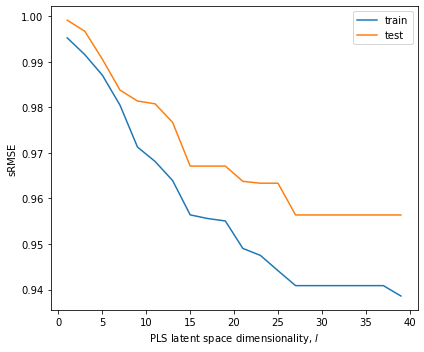

29 components with nRMSE = 0.9563785995361743


In [14]:
plt.figure(figsize=(6, 5))
x = np.array(range(1,40,2))
y1_mean = np.array([np.mean(r[2]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==2)]
y2_mean = np.array([np.mean(r[3]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==2)]
y1_std = np.array([np.std(r[2]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==2)]
y2_std = np.array([np.std(r[3]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==2)]

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_HOPLS.pdf', format='pdf')
plt.show()
    
print(x[np.argmin(np.array(y2_mean))+1],'components with nRMSE =', min(y2_mean))

In [15]:
n_restarts = 5
start = time()
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_t_train),torch.tensor(Y_train), torch.tensor(X_t_test), torch.tensor(Y_test),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
HOPLS_time = end-start
HOPLS_rmse_test = np.mean(te)
HOPLS_rmse_train = np.mean(tr)
HOPLS_rmse_test_std = np.std(te)
HOPLS_rmse_train_std = np.std(te)
print('Time:', HOPLS_time)
print('Train rmse:', HOPLS_rmse_train,'±',HOPLS_rmse_train_std)
print('Test rmse:', HOPLS_rmse_test,'±',HOPLS_rmse_test_std)

Time: 39.07697916030884
Train rmse: 0.9408636923701422 ± 2.2375883352003356e-15
Test rmse: 0.9563785995361765 ± 2.2375883352003356e-15


# 2d-PCA + PLS

In [6]:
import numpy as np
import scipy.linalg as s_linalg


class two_d_pca_class:


    def give_p(self, d):
        #print("D", d)
        sum = np.sum(d)
        sum_85 = self.p * sum
        temp = 0
        p = 0
        while temp < sum_85:
            temp += d[p]
            p += 1
        return p

    def reduce_dim(self):

        no_of_images = self.images.shape[0]
        mat_height = self.images.shape[1]
        mat_width = self.images.shape[2]
        g_t = np.zeros((mat_width, mat_width))
        h_t = np.zeros((mat_height, mat_height))

        for i in range(no_of_images):
            temp = np.dot(self.images_mean_subtracted[i].T, self.images_mean_subtracted[i])
            #print(temp.shape,g_t.shape,h_t.shape)
            g_t += temp
            h_t += np.dot(self.images_mean_subtracted[i], self.images_mean_subtracted[i].T)

        g_t /= no_of_images
        h_t /= no_of_images

        #For G_T
        d_mat, p_mat = np.linalg.eig(g_t)
        p_1 = self.give_p(d_mat)
        self.new_bases_gt = p_mat[:, 0:p_1]

        #For H_T
        d_mat, p_mat = np.linalg.eig(h_t)
        p_2 = self.give_p(d_mat)
        self.new_bases_ht = p_mat[:, 0:p_2]


        new_coordinates_temp = np.dot(self.images, self.new_bases_gt)

        self.new_coordinates = np.zeros((no_of_images, p_2, p_1))

        for i in range(no_of_images):
            self.new_coordinates[i, :, :] = np.dot(self.new_bases_ht.T, new_coordinates_temp[i])

        return self.new_coordinates


    def __init__(self, images,p):
        self.images = np.asarray(images)
        self.mean_face = np.mean(self.images, 0)
        self.p = p
        self.images_mean_subtracted = self.images - self.mean_face


    def original_data(self, new_coordinates):
        return np.dot(self.new_bases_ht, np.dot(new_coordinates, self.new_bases_gt.T))


    def new_cord_for_image(self, image):
        new_image = np.zeros((image.shape[0],self.new_bases_ht.shape[1],self.new_bases_gt.shape[1]))
        for i in range(image.shape[0]):
            new_image[i,:,:] = np.dot(self.new_bases_ht.T, np.dot(image[i,:,:], self.new_bases_gt))
        return new_image



In [19]:
n_restarts = 5
rmse = []
for p in np.arange(0.9,1,0.005):
        pca = two_d_pca_class(X_t_train,p)
        X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
        X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
        for k in range(1, 4):
            pls = PLSRegression(n_components=k)
            tr = []
            te = []
            for i in range(n_restarts):
                X, Y = X_n_train, Y_train
                pls.fit(X, Y)
                tr.append(metric_nmse(X, Y, pls))
                te.append(metric_nmse(X_n_test, Y_test, pls))
            rmse.append((k, tr, te, p))

In [20]:
y2_mean = np.array([np.mean(r[2]) for r in rmse])
p = rmse[np.argmin(y2_mean)][3]
print('percentage of information:', round(p*100,2), 'RMSE fo test:', np.mean(rmse[np.argmin(y2_mean)][2]))

percentage of information: 98.5 RMSE fo test: 0.93205611724303


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

(12801, 392) (6087, 392)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [02:04<00:00,  8.91s/it]


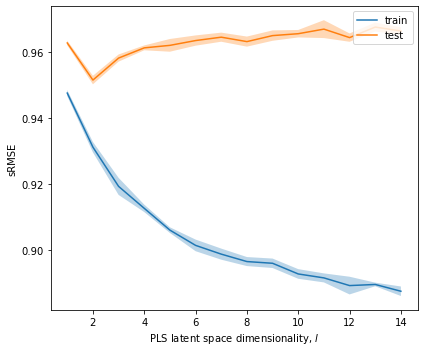

2 components with nRMSE = 0.951617553069213


In [21]:
pca = two_d_pca_class(X_t_train,rmse[np.argmin(y2_mean)][3])
X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
print(X_n_train.shape,X_n_test.shape)
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 15)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_MPCA+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))


In [25]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train,p)
X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
MPCA_PLS_time = end-start
MPCA_PLS_rmse_test = np.mean(te)
MPCA_PLS_rmse_train = np.mean(tr)
MPCA_PLS_rmse_test_std = np.std(te)
MPCA_PLS_rmse_train_std = np.std(te)
print('Time:', MPCA_PLS_time)
print('Train rmse:', MPCA_PLS_rmse_train,'±',MPCA_PLS_rmse_train_std)
print('Test rmse:', MPCA_PLS_rmse_test,'±',MPCA_PLS_rmse_test_std)

Time: 3.036234140396118
Train rmse: 0.9311366196847969 ± 0.0016757185868778517
Test rmse: 0.9525279103818303 ± 0.0016757185868778517


# 2d-PCA + HOPLS

In [8]:
RMSE_pca_hopls = []
for p in np.arange(0.98,0.999,0.005):
        pca = two_d_pca_class(X_t_train,p)
        X_n_train = pca.reduce_dim()
        X_n_test = pca.new_cord_for_image(X_t_test)
        for R in range(1,30,2):
            for l in range(1,4):
                rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_n_train),torch.tensor(Y_train), torch.tensor(X_n_test), torch.tensor(Y_test),l,R)
                #Q_hopls.append([R,l,Q])
                RMSE_pca_hopls.append([p,R,l,rmse_tr, rmse_te])
y2_mean = np.array([r[4] for r in RMSE_pca_hopls])
p = RMSE_pca_hopls[np.argmin(y2_mean)][0]
R = RMSE_pca_hopls[np.argmin(y2_mean)][1]
l = RMSE_pca_hopls[np.argmin(y2_mean)][2]
print('p:',p,'  R:',R, '  l:',l,'  Test rmse:', RMSE_pca_hopls[np.argmin(y2_mean)][4])

p: 0.995   R: 29   l: 2   Test rmse: 0.956421995618058


In [9]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train,p)
X_n_train = pca.reduce_dim()
X_n_test = pca.new_cord_for_image(X_t_test)
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
MPCA_HOPLS_time = end-start
MPCA_HOPLS_rmse_test = np.mean(te)
MPCA_HOPLS_rmse_train = np.mean(tr)
MPCA_HOPLS_rmse_test_std = np.std(te)
MPCA_HOPLS_rmse_train_std = np.std(te)
print('Time:', MPCA_HOPLS_time)
print('Train rmse:', MPCA_HOPLS_rmse_train,'±',MPCA_HOPLS_rmse_train_std)
print('Test rmse:', MPCA_HOPLS_rmse_test,'±',MPCA_HOPLS_rmse_test_std)

Time: 43.193947315216064
Train rmse: 0.9630117449296073 ± 5.135906591666906e-16
Test rmse: 0.971906621711869 ± 5.135906591666906e-16
